Code demonstration for binning cardiac real-time MRI with signal intensity values obtained from region of interests that reflect the diaphragm's position

In [ ]:
# import dicom packages

import collections
import datetime
import glob
import math as mt
import os
from math import floor
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
import pydicom.filewriter
import scipy as sc
from scipy.signal import filtfilt
from skimage.registration import phase_cross_correlation
import statistics

%matplotlib inline

In [2]:
# helper function to compare real-time images using phase cross correlation

def phase_corr_error(image1, image2):
    shift, error, diffphase = phase_cross_correlation(image1, image2, upsample_factor=100)
    return error


# function to import dicom images, their given aquisition time (sorted and not sorted) and their amount as arrays
def read_dicomDir(input_dir):
    listPathDicom = []
    input_slices = os.listdir(input_dir)
    listPathDicom = [os.path.join(input_dir, path) for path in input_slices]
    listPathDicom.sort()
    # create Dir to save data and pictures
    amountFrames = len(listPathDicom)
    RefDs = [{}] * amountFrames
    AT = np.zeros([amountFrames, 2])
    AT[:, 0] = range(0, amountFrames)
    RefDs[0] = pydicom.dcmread(listPathDicom[0])
    ArrayDicom = np.zeros([200, 200, amountFrames], dtype=RefDs[0].pixel_array.dtype)
    # np.zeros([][200,200,amountFrames]],[amountFrames])
    for filenameDCM in listPathDicom:
        ds = pydicom.dcmread(filenameDCM)
        AT[listPathDicom.index(filenameDCM), 1] = float(ds.AcquisitionTime)
        ArrayDicom[:, :, listPathDicom.index(filenameDCM)] = ds.pixel_array  # store the raw image data
    # sort by acquisition time
    sortedArr = AT[AT[:, 1].argsort()]
    sortedDicom = ArrayDicom[:, :, AT[:, 1].argsort()]
    return (sortedDicom, sortedArr, AT, amountFrames)


# function to convert the aquisition time, aquired through dicom tags, into miliseconds after midnight time format

def timeConverter(time_AT):
    hours = mt.floor(time_AT / 10000)
    hours_ms = hours * 60 * 60 * 1000
    min = mt.floor((time_AT - 10000 * hours) / 100)
    min_ms = min * 60 * 1000
    sec = mt.floor(time_AT - (10000 * hours) - (100 * min))
    sec_ms = sec * 1000
    ms = mt.floor((time_AT - (10000 * hours) - (100 * min) - sec) * 1000)
    com_ms = ms + sec_ms + min_ms + hours_ms
    return com_ms


# convert dicom timestamps

def convert_dicom_time(dicomtime):
    """
    Convert timestamp from dicom
    """
    dicomtime = dicomtime.strip('b\'')
    dicomhours = int(str(dicomtime)[0:2])
    dicomminutes = int(str(dicomtime)[2:4])
    dicomseconds = int(str(dicomtime)[4:6])
    dicommilliseconds = int(float(str(dicomtime)[6:]) * 1000)
    return datetime.datetime(2000, 1, 1, dicomhours, dicomminutes, dicomseconds, dicommilliseconds * 1000)


# helper function that creates folders

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# fill empty bins by picking scans from same ecg group but different volume group

def find_closest_from_other_bin(mid, scans_sort_by_ecg, vol_group, slc, ecg_group, ):
    vol_groups = list(scans_sort_by_ecg[slc][ecg_group].keys())
    distances = None
    for vol_group in vol_groups:
        group = scans_sort_by_ecg[slc][ecg_group][vol_group]
        volumes = [float(scan.get_item((0x08, 0x04)).value) for scan in group]
        if len(volumes) > 0:
            final_group = group.copy()
            distances = np.array(volumes) - mid

    return final_group[np.argmin(distances)] if distances is not None else None

# helper function to import and export excel files

def load_excel(file):
    return pd.read_excel(file)


def excel_to_dic(ds, slices=None):
    if slices is None:
        slices = list(set(ds['imageSeriesNumber']))
    data = {str(s): [] for s in slices}
    for i in range(ds.shape[0]):
        t = ds.iloc[i]
        if t['id'] == 'siMedian':
            data[str(t['imageSeriesNumber'])].append({'imageInstanceNumber': t['imageInstanceNumber'],
                                                      'ns1:Value': t['ns1:Value']})
    data_sort = {}
    for slice in slices:
        slice_data = data[str(slice)]
        if len(slice_data) == 0:
            continue
        index = 0
        count = 0
        sort_slice_data = [[] for _ in range(len(slice_data))]
        for i in range(len(slice_data)):
            if index + 1 != int(slice_data[i]['imageInstanceNumber']):
                count = count - 1
                print(count)
            index = int(slice_data[i]['imageInstanceNumber'])
            try:
                sort_slice_data[slice_data[i]['imageInstanceNumber'] - 1 + count] = {
                    'imageInstanceNumber': slice_data[i]['imageInstanceNumber'],
                    'ns1:Value': slice_data[i]['ns1:Value']}
            except:
                print(i)

        sort_slice_data = sort_slice_data[:count]
        data_sort[str(slice)] = sort_slice_data
    return data_sort

# helper function to plot signal intensity values

def show_slice(data: dict, slice: int):
    keys = data.keys()
    if str(slice) not in keys:
        print(f'{keys}')
        return None
    values = [int(v['ns1:Value']) for v in data[str(slice)]]
    values_median = [int(v.get('median')) if v.get('median') is not None else None for v in data[str(slice)]]
    xs = [i for i in range(len(values))]
    plt.plot(xs, values, xs, values_median)
    plt.show()
    flows = [int(v.get('flow')) if v.get('flow') is not None else None for v in data[str(slice)]]
    flows_median = [int(v.get('median_flow')) if v.get('median_flow') is not None else None for v in data[str(slice)]]
    plt.plot(xs, flows, xs, flows_median)
    plt.show()

# helper function to build the median values for signal intensity values and the flow curve.
    
def preprocessing(data, calc_range):
    keys = data.keys()
    for key in keys:
        slice_data = data[key]
        values = []
        flows = []
        length = len(slice_data)
        for i in range(length):
            if i < 2 * calc_range:
                values.append(int(slice_data[i]['ns1:Value']))
                continue
            if i > len(slice_data) - calc_range:
                break
            values = values[1:]
            values.append(int(slice_data[i]['ns1:Value']))
            slice_data[i - calc_range]['median'] = np.median(np.array(values))
            if i > 2 * calc_range + 1:
                slice_data[i - 1 - calc_range]['flow'] = (slice_data[i - calc_range]['median'] -
                                                          slice_data[i - 2 - calc_range]['median']) / 2
                flows.append(slice_data[i - 1 - calc_range]['flow'])
            if i > 3 * calc_range + 1 and len(flows) >= 2 * calc_range:
                slice_data[i - 1 - calc_range]['median_flow'] = np.median(np.array(flows))
                flows = flows[1:]
        data[key] = slice_data
    return data

# helper function to load excel files

def load_excel(file):
    return pd.read_excel(file)


def excel_to_dic(ds, slices=None):
    if slices is None:
        slices = list(set(ds['imageSeriesNumber']))
    data = {str(s): [] for s in slices}
    for i in range(ds.shape[0]):
        t = ds.iloc[i]
        if t['id'] == 'siMedian':
            data[str(t['imageSeriesNumber'])].append({'imageInstanceNumber': int(t['imageInstanceNumber']),
                                                      'ns1:Value': float(t['ns1:Value'])})
    data_sorted = {}
    for slice in slices:
        slice_data = data[str(slice)]
        if len(slice_data) == 0:
            continue
        imageInstanceNumbers = [_['imageInstanceNumber']for _ in slice_data]
        data_sorted[str(slice)] = [slice_data[i] for i in list(np.argsort(imageInstanceNumbers))]

    slice_offset = np.array([int(k) for k in data_sorted.keys()]).min()
    return data_sorted, slice_offset - 1

# helper function to calculate the derivation

def calc_derivation(y_values, dx=1):
    return np.diff(y_values)/dx

# helper functions to calculate the median value of the flow curve

def calc_flow(data, calc_range):
    median_values = [d.get('ns1:Value_median') for d in data[calc_range:-calc_range]]
    flows = calc_derivation(median_values, 1)
    for index in range(calc_range,len(data)-calc_range -1):
        data[index + 1]['flow'] = flows[index - calc_range]


def calc_medians(data, key, calc_range):
    for index in range(calc_range, len(data) - calc_range):
        calc_median(data, key, index, calc_range)


def calc_median(data, key, index, calc_range):
    if index - calc_range < 0 or index + calc_range > len(data):
        return
    values = [_.get(key) for _ in data[index-calc_range:index+calc_range]]
    if None in values:
        return None
    median = statistics.median(values)
    data[index][key + "_median"] = median


def preprocessing(data, calc_range):
    slices = data.keys()
    for slice in slices:
        slice_data = data[slice]
        calc_medians(slice_data, 'ns1:Value', calc_range)
        calc_flow(slice_data, calc_range)
        calc_medians(slice_data, 'flow', calc_range)


# helper function to plot the SI curves, the median data of the SI curves, the flow curve and the median data of the flow curve

def show_slice(data: dict, slice: int):
    keys = data.keys()
    if str(slice) not in keys:
        print(f'{keys}')
        return None
    values = [int(v['ns1:Value']) for v in data[str(slice)]]
    values_median = [int(v.get('ns1:Value_median')) if v.get('ns1:Value_median') is not None else None for v in data[str(slice)]]
    xs = [i for i in range(len(values))]
    plt.plot(xs, values,xs,values_median)
    plt.show()
    flows = [int(v.get('flow')) if v.get('flow') is not None else None for v in data[str(slice)]]
    flows_median = [int(v.get('flow_median')) if v.get('flow_median') is not None else None for v in data[str(slice)]]
    plt.plot(xs, flows,xs,flows_median)
    plt.show()
    

In [3]:
# import tool for the Excel file of the SI data and the real-time images
file = r'C:\Users\roelen01\Desktop\notebook-demonstration\Sort-data-Echtzeit040-neu-8-Atemklassen20220323\SI-Echtzeit040-Slice03-14.xlsx'
# range for the determination of the median values
calc_range = 10
listPathDicom = []
inputdir_dicom = r'C:\Users\roelen01\Desktop\notebook-demonstration\Dicom-data-real-time'
# defining the duration of an ECG class
ecg_step_size = 24

In [4]:
#load excel file
ds = load_excel(file)

In [5]:
# sorting SI values from the excel file to the right slice number of the short axis stack
data, slice_offset = excel_to_dic(ds)
preprocessing(data, calc_range)
slices_names = glob.glob(inputdir_dicom + '\*')
print(slices_names)

['D:\\Forschungsstelle\\Patienten-Echtzeit-Volumetrie-Studie-2\\Patienten\\Patient-Echtzeit040\\alt-8-Atemklassen-ohne-Flussunterscheidung\\Sort-data-Echtzeit040-neu-8-Atemklassen20220323\\Echtzeit-einzeln\\Slice03', 'D:\\Forschungsstelle\\Patienten-Echtzeit-Volumetrie-Studie-2\\Patienten\\Patient-Echtzeit040\\alt-8-Atemklassen-ohne-Flussunterscheidung\\Sort-data-Echtzeit040-neu-8-Atemklassen20220323\\Echtzeit-einzeln\\Slice04', 'D:\\Forschungsstelle\\Patienten-Echtzeit-Volumetrie-Studie-2\\Patienten\\Patient-Echtzeit040\\alt-8-Atemklassen-ohne-Flussunterscheidung\\Sort-data-Echtzeit040-neu-8-Atemklassen20220323\\Echtzeit-einzeln\\Slice05', 'D:\\Forschungsstelle\\Patienten-Echtzeit-Volumetrie-Studie-2\\Patienten\\Patient-Echtzeit040\\alt-8-Atemklassen-ohne-Flussunterscheidung\\Sort-data-Echtzeit040-neu-8-Atemklassen20220323\\Echtzeit-einzeln\\Slice06', 'D:\\Forschungsstelle\\Patienten-Echtzeit-Volumetrie-Studie-2\\Patienten\\Patient-Echtzeit040\\alt-8-Atemklassen-ohne-Flussunterscheidu

In [6]:
# correctation factor to sort the right slice number to the corresponding SI values in the Excel file
correctation_Factor = -2
print("Calculated Instance Numbers")
for slice_name in slices_names:
    print(f"Slice: {slice_name} - Instance Number: {int(slice_name[-2:]) + slice_offset + correctation_Factor}")

Calculated Instance Numbers
Slice: D:\Forschungsstelle\Patienten-Echtzeit-Volumetrie-Studie-2\Patienten\Patient-Echtzeit040\alt-8-Atemklassen-ohne-Flussunterscheidung\Sort-data-Echtzeit040-neu-8-Atemklassen20220323\Echtzeit-einzeln\Slice03 - Instance Number: 59
Slice: D:\Forschungsstelle\Patienten-Echtzeit-Volumetrie-Studie-2\Patienten\Patient-Echtzeit040\alt-8-Atemklassen-ohne-Flussunterscheidung\Sort-data-Echtzeit040-neu-8-Atemklassen20220323\Echtzeit-einzeln\Slice04 - Instance Number: 60
Slice: D:\Forschungsstelle\Patienten-Echtzeit-Volumetrie-Studie-2\Patienten\Patient-Echtzeit040\alt-8-Atemklassen-ohne-Flussunterscheidung\Sort-data-Echtzeit040-neu-8-Atemklassen20220323\Echtzeit-einzeln\Slice05 - Instance Number: 61
Slice: D:\Forschungsstelle\Patienten-Echtzeit-Volumetrie-Studie-2\Patienten\Patient-Echtzeit040\alt-8-Atemklassen-ohne-Flussunterscheidung\Sort-data-Echtzeit040-neu-8-Atemklassen20220323\Echtzeit-einzeln\Slice06 - Instance Number: 62
Slice: D:\Forschungsstelle\Patienten

dict_keys(['64', '65', '66', '67', '68', '69', '70', '59', '60', '61', '62', '63'])


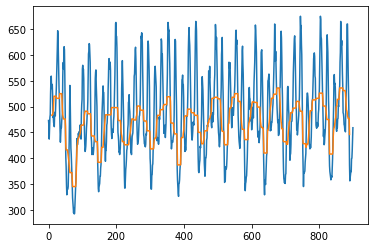

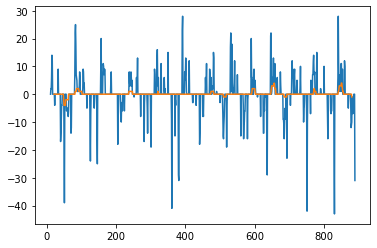

In [7]:
# plotting tool for the different SI curves from the different slices
slice_nr = 8
print(data.keys())
show_slice(data,slice_nr + slice_offset + correctation_Factor)

In [8]:
# defining the SI value threshholds for end-inspiration and end-expiration individually for all slices
insp_thresholds_min = [475, 550, 300, 425, 480, 440, 300, 275, 400, 400, 700, 600]
exp_thresholds_max = [950, 950, 400, 625, 520, 500, 375, 325, 450, 450, 1000, 1250]

In [9]:
# possibility to define a narrower range of the SI values that should serve for respiratory binning
deltas = [i - ii for i, ii in zip(exp_thresholds_max, insp_thresholds_min)]
insp_thresholds = [m + 0.01 * d for d, m in zip(deltas, insp_thresholds_min)]
exp_thresholds = [m + 0.99 * d for d, m in zip(deltas, insp_thresholds_min)]
deltas = [(i - ii)/2 for i, ii in zip(exp_thresholds, insp_thresholds)]
print(insp_thresholds)
print(exp_thresholds)
print(deltas)

[479.75, 554.0, 301.0, 427.0, 480.4, 440.6, 300.75, 275.5, 400.5, 400.5, 703.0, 606.5]
[945.25, 946.0, 399.0, 623.0, 519.6, 499.4, 374.25, 324.5, 449.5, 449.5, 997.0, 1243.5]
[232.75, 196.0, 49.0, 98.0, 19.600000000000023, 29.399999999999977, 36.75, 24.5, 24.5, 24.5, 147.0, 318.5]


In [10]:
for kk, slice_name in enumerate(slices_names):
        insp_threshold = insp_thresholds[kk]
        exp_threshold = exp_thresholds[kk]
        delta = deltas[kk]

        slice_data = data[str(int(slice_name[-2:]) + slice_offset + correctation_Factor)]
        slice_name = os.path.basename(slice_name)
        inputdir_first_slice = inputdir_dicom + '/' + slice_name

        #ArrayDicom, sortedArr, AT, amountFrames = read_dicomDir(inputdir_first_slice)

        # specify folder containing scans as DICOMs
        folder = inputdir_dicom

        # build path:
        # as long as there is only one folder add this folder to the path
        path = folder + '/'
        while len(os.listdir(path)) == 1:
            path += os.listdir(path)[0] + '/'
            print(path)

        scans = {}  # dictionary containing a dictonary of dicom files
        i = 0
        dirs = os.listdir(path)
        folder = slice_name

        current = path + folder
        scan = {}

        for file in os.listdir(current):
            if file == '.DS_Store':
                continue
            i += 1
            current_file = current + '/' + file
            scan[file] = pydicom.dcmread(current_file, force=True)
        print("Read files from", current)
        scans[folder] = scan
        print("Read", i, "files")

        # scans is a dictionary containing all sclices
        scans.keys()

        # count imported dicom files
        total = 0
        for k in scans.keys():
            print(k)
            total += len(scans[k])
            print(len(scans[k]))
        print('total:', total)

        scans[slice_name] = collections.OrderedDict(sorted(scans[slice_name].items()))

        count = 0
        for slice_name in scans:
            for image_name in scans[slice_name]:
                current_scan = scans[slice_name][image_name]
                ecg = str(current_scan.get_item((0x18, 0x1060)).value).strip('b\'')
                current_scan[0x20, 0x0013].value = floor(float(ecg))  # forget decimal places
                count += 1
        print(count, 'images processed')

        # sort all imported scans by their filename
        from collections import OrderedDict

        scans_sort = OrderedDict(sorted(scans.items()))
        list(scans_sort.keys())

        for scan in scans_sort:
            d = scans_sort[scan]
            scans_sort[scan] = OrderedDict(sorted(d.items()))

        # writing the values for SI and Flow median in new dicom tags

        for i in scans_sort:
            for count, j in enumerate(scans_sort[i]):
                current_scan = scans_sort[i][j]
                f = slice_data[count].get('flow_median')
                if f is None:
                    continue
                scans_sort[i][j].add_new((0x08, 0x03), 'LO', str(f))
                
                v = slice_data[count].get('ns1:Value_median')
                scans_sort[i][j].add_new((0x08, 0x04), 'LO', str(v))

        # binning in ecg groups and respiratory classes
      
        count = 0
        scans_sort_by_ecg = {}
        for i in scans_sort:
            scans_sort_by_ecg[i] = {}
            for j in scans_sort[i]:
                count += 1
                current_scan = scans_sort[i][j]
                ecg = float(str(current_scan.get_item((0x18, 0x1060)).value).strip('b\''))
                ecg_group = int((ecg + 16.5) // ecg_step_size)  # calculate group id
                if ecg_group == 25:
                    ecg_group = 0
                if ecg_group > 25:
                    continue
                if ecg_group not in scans_sort_by_ecg[i].keys():
                    scans_sort_by_ecg[i][ecg_group] = [[], [], [], [], [], [], [], []]
                if current_scan.get_item((0x08, 0x03)) is None:
                    continue
                if current_scan.get_item((0x08, 0x04)) is None:
                    continue
                if float(current_scan.get_item((0x08, 0x03)).value) <= 0:
                    #inspiration
                    if float(current_scan.get_item((0x08, 0x04)).value) <= insp_threshold:
                        scans_sort_by_ecg[i][ecg_group][0].append(current_scan)
                    elif float(current_scan.get_item((0x08, 0x04)).value) <= insp_threshold + delta:
                        scans_sort_by_ecg[i][ecg_group][1].append(current_scan)
                    elif float(current_scan.get_item((0x08, 0x04)).value) <= insp_threshold + 2 * delta:
                        scans_sort_by_ecg[i][ecg_group][2].append(current_scan)
                    elif float(current_scan.get_item((0x08, 0x04)).value) <= insp_threshold + 3 * delta:
                        scans_sort_by_ecg[i][ecg_group][3].append(current_scan)
                if float(current_scan.get_item((0x08, 0x03)).value) > 0:
                    #exspiration
                    if float(current_scan.get_item((0x08, 0x04)).value) >= exp_threshold:
                        scans_sort_by_ecg[i][ecg_group][4].append(current_scan)
                    elif float(current_scan.get_item((0x08, 0x04)).value) >= exp_threshold - delta:
                        scans_sort_by_ecg[i][ecg_group][5].append(current_scan)
                    elif float(current_scan.get_item((0x08, 0x04)).value) >= exp_threshold - 2*delta:
                        scans_sort_by_ecg[i][ecg_group][6].append(current_scan)
                    elif float(current_scan.get_item((0x08, 0x04)).value) >= exp_threshold - 3*delta:
                        scans_sort_by_ecg[i][ecg_group][7].append(current_scan)
                    

        print(count, 'images processed')

        # count number of scans in each bin
        # table containing number of scans for each bin
        
        df = pd.DataFrame({'Slice': [], 'ECG': [], 'Vol': [], 'Number': []})

        for slc in scans_sort_by_ecg:
            for ecg_group in scans_sort_by_ecg[slc]:
                for vol_group in range(len(scans_sort_by_ecg[slc][ecg_group])):
                    number_of_scans = len(scans_sort_by_ecg[slc][ecg_group][vol_group])
                    # count scans per bin
                    new_row = pd.DataFrame([[slc, ecg_group,
                                             vol_group, number_of_scans]], columns=['Slice', 'ECG', 'Vol', 'Number'])
                    df = df.append(new_row)

        # export table containing number of scans for each bin
        df = df.sort_values(['Vol', 'Slice', 'ECG'])
        ensure_dir('measurements_realtime/')
        df.to_csv('measurements_realtime/' + inputdir_dicom[-3:] + slice_name[-7:] + '.csv')

        print(sum(df['Number']))

        # export all binned scans
        # no filling of empty bins or picking scans of bins containing more than one scan
        for slc in scans_sort_by_ecg:
            for ecg_group in scans_sort_by_ecg[slc]:
                for vol_group in range(len(scans_sort_by_ecg[slc][ecg_group])):
                    for i, to_export in enumerate(scans_sort_by_ecg[slc][ecg_group][vol_group]):
                        path_to_save = './output_all_slices' + '/' + str(vol_group) + '/' + str(
                            slc) + '/' + str(ecg_group) + '/'
                        ensure_dir(path_to_save)
                        # print(path_to_save+'scan'+'.dcm')
                        pydicom.filewriter.dcmwrite(path_to_save + 'scan' + str(i) + '.dcm', to_export)
                        
        # if more than two images per bin, comparing of images using phase cross correlation
        # export all images after phase correlation

        empty_dirs = []
        for slc in scans_sort_by_ecg:
            for ecg_group in scans_sort_by_ecg[slc]:
                for vol_group in range(len(scans_sort_by_ecg[slc][ecg_group])):
                    group = scans_sort_by_ecg[slc][ecg_group][vol_group].copy()

                    dicom_images = [scan.pixel_array for scan in group]
                    
                    if len(dicom_images) == 0:
                        empty_dirs.append((slc,vol_group,ecg_group))
                        print(f"Slice_{slc}_ECG_{ecg_group}_VOL_{vol_group}")
                        continue
                    if len(dicom_images) > 2:
                        dif = []
                        for image1 in dicom_images:
                            error = 0
                            for image2 in dicom_images:
                                error += phase_corr_error(image1, image2)
                            dif.append(error)
                        dif = np.array(dif)
                        boundary = dif.mean() + dif.std()
                        export_bool = [True if dif[i] < boundary else False for i in range(len(dicom_images))]

                    for i, to_export in enumerate(scans_sort_by_ecg[slc][ecg_group][vol_group]):
                        path_to_save = './output_all_slices_after_phase_correlation' + '/' + str(vol_group)+ '/' + str(
                            slc) + '/' + str(ecg_group) + '/'
                        ensure_dir(path_to_save)
                        # print(path_to_save+'scan'+'.dcm')
                        if export_bool[i]:
                            pydicom.filewriter.dcmwrite(path_to_save + 'scan' + str(i) + '.dcm', to_export)
                            
        # in case of empty classes, picking of images from a neighbouring respiratory class in the same ECG class

    
        vol_groups = glob.glob('./output_all_slices_after_phase_correlation/*')
        for vol_group in vol_groups:
            ecgs = glob.glob(vol_group + os.sep + slice_name + os.sep + '*')
            values = []
            for ecg in ecgs:
                dicoms = glob.glob(ecg + os.sep + '*')
                for dicom in dicoms:
                    values.append(float(pydicom.dcmread(dicom).get_item((0x08, 0x04)).value))
            mean_value = np.median(np.array(values))
            print(vol_group, mean_value)
            for ecg in ecgs:
                values = []
                dicoms = glob.glob(ecg + os.sep +'*')
                if len(dicoms) == 0:
                    continue
                path_to_save = './output' + '/' + str(os.path.basename(vol_group)) + '/' + str(slc) + '/' + str(os.path.basename(ecg)) + '/'
                ensure_dir(path_to_save)
                if len(dicoms) > 1:
                    for dicom in dicoms:
                        values.append(float(pydicom.dcmread(dicom).get_item((0x08, 0x04)).value))
                    values = np.array([abs(v - mean_value) for v in values])
                    idx = np.argmin(values)
                    to_export = pydicom.dcmread(dicoms[idx])
                else:
                    to_export = pydicom.dcmread(dicoms[0])
                pydicom.filewriter.dcmwrite(path_to_save + 'scan' + '.dcm', to_export)                

        for empty_dir in empty_dirs:
            slc,vol_group,ecg_group = empty_dir
            skip = 0
            while True:
                if vol_group == 0:
                    source_vol_group = 7 - skip
                else:
                    source_vol_group = vol_group - 1 - skip
                    if source_vol_group < 0:
                        source_vol_group = 7

                images = glob.glob('./output' + '/' + str(source_vol_group) + '/' + str(slc) + '/' + str(
                            ecg_group) + '/*.dcm')
                if skip > 10:
                    print(empty_dir)
                    break
                if len(images) == 0:
                    skip += 1
                    continue
                source_dicom = images[0]
                to_export = pydicom.dcmread(source_dicom)
                path_to_save = './output' + '/' + str(vol_group) + '/' + str(slc) + '/' + str(
                            ecg_group) + '/'
                ensure_dir(path_to_save)
                pydicom.filewriter.dcmwrite(path_to_save + 'scan' + '.dcm', to_export)
                break

Read files from D:\Forschungsstelle\Patienten-Echtzeit-Volumetrie-Studie-2\Patienten\Patient-Echtzeit040\alt-8-Atemklassen-ohne-Flussunterscheidung\Sort-data-Echtzeit040-neu-8-Atemklassen20220323\Echtzeit-einzeln/Slice03
Read 900 files
Slice03
900
total: 900
900 images processed
900 images processed
761.0
Slice_Slice03_ECG_3_VOL_7
Slice_Slice03_ECG_4_VOL_6
Slice_Slice03_ECG_6_VOL_7
Slice_Slice03_ECG_7_VOL_7
Slice_Slice03_ECG_8_VOL_7
Slice_Slice03_ECG_10_VOL_6
Slice_Slice03_ECG_10_VOL_7
Slice_Slice03_ECG_13_VOL_2
Slice_Slice03_ECG_13_VOL_6
Slice_Slice03_ECG_17_VOL_5
Slice_Slice03_ECG_17_VOL_7
Slice_Slice03_ECG_20_VOL_6
Slice_Slice03_ECG_24_VOL_1
Slice_Slice03_ECG_24_VOL_5
Slice_Slice03_ECG_5_VOL_7
Slice_Slice03_ECG_9_VOL_7
Slice_Slice03_ECG_12_VOL_7
Slice_Slice03_ECG_16_VOL_6
Slice_Slice03_ECG_19_VOL_2
Slice_Slice03_ECG_19_VOL_5
Slice_Slice03_ECG_23_VOL_1
./output_all_slices_after_phase_correlation\0 363.5
./output_all_slices_after_phase_correlation\1 514.0
./output_all_slices_after_pha

Read files from D:\Forschungsstelle\Patienten-Echtzeit-Volumetrie-Studie-2\Patienten\Patient-Echtzeit040\alt-8-Atemklassen-ohne-Flussunterscheidung\Sort-data-Echtzeit040-neu-8-Atemklassen20220323\Echtzeit-einzeln/Slice09
Read 900 files
Slice09
900
total: 900
900 images processed
900 images processed
743.0
Slice_Slice09_ECG_10_VOL_4
Slice_Slice09_ECG_14_VOL_2
Slice_Slice09_ECG_18_VOL_1
Slice_Slice09_ECG_22_VOL_1
Slice_Slice09_ECG_24_VOL_5
Slice_Slice09_ECG_2_VOL_7
Slice_Slice09_ECG_3_VOL_7
./output_all_slices_after_phase_correlation\0 262.75
./output_all_slices_after_phase_correlation\1 322.5
./output_all_slices_after_phase_correlation\2 351.0
./output_all_slices_after_phase_correlation\3 392.0
./output_all_slices_after_phase_correlation\4 392.0
./output_all_slices_after_phase_correlation\5 354.5
./output_all_slices_after_phase_correlation\6 316.5
./output_all_slices_after_phase_correlation\7 283.5
Read files from D:\Forschungsstelle\Patienten-Echtzeit-Volumetrie-Studie-2\Patienten\Pati

In [64]:
# in case of more than one imager per bin after phase correlation picking of images closest to the median 
# SI value in the corresponding respiratory class  

    vol_groups = glob.glob('./output_all_slices_after_phase_correlation/*')
        for vol_group in vol_groups:
            ecgs = glob.glob(vol_group + os.sep + slice_name + os.sep + '*')
            values = []
            for ecg in ecgs:
                dicoms = glob.glob(ecg + os.sep + '*')
                values = []
                for dicom in dicoms:
                    values.append(float(pydicom.dcmread(dicom).get_item((0x08, 0x04)).value))
            mean_value = np.array(values).mean()
            print(vol_group, mean_value)
            for ecg in ecgs:
                values = []
                dicoms = glob.glob(ecg + os.sep +'*')
                if len(dicoms) == 0:
                    continue
                path_to_save = './output' + '/' + str(os.path.basename(vol_group)) + '/' + str(slc) + '/' + str(os.path.basename(ecg)) + '/'
                ensure_dir(path_to_save)
                if len(dicoms) > 1:
                    for dicom in dicoms:
                        values.append(float(pydicom.dcmread(dicom).get_item((0x08, 0x04)).value))
                    values = np.array([abs(v - mean_value) for v in values])
                    idx = np.argmin(values)
                    to_export = pydicom.dcmread(dicoms[idx])
                else:
                    to_export = pydicom.dcmread(dicoms[0])
                pydicom.filewriter.dcmwrite(path_to_save + 'scan' + '.dcm', to_export)
                

./output_all_slices_after_phase_correlation\0 347.1875
./output_all_slices_after_phase_correlation\1 601.5
./output_all_slices_after_phase_correlation\2 816.25
./output_all_slices_after_phase_correlation\3 1016.5833333333334
./output_all_slices_after_phase_correlation\4 1053.5
./output_all_slices_after_phase_correlation\5 833.3
./output_all_slices_after_phase_correlation\6 620.0
./output_all_slices_after_phase_correlation\7 357.0
